<a href="https://colab.research.google.com/github/oscar-defelice/Computer-Vision-Hands-on/blob/main/FinalProjectComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Hands-on
## Final Project

Questo notebook costituisce il final project del corso *Computer Vision Hands-on*.

### Obiettivo

> Costruire un modello di riconoscimento immagini tramite *Siamese Network*. Il modello dovrà avere una AUC/ROC di almeno 0.87 sul test set.

Il dataset da utilizzare sarà il famoso [MNIST](https://www.tensorflow.org/datasets/catalog/mnist). 

Utilizzeremo questo dataset per costruire e allenare una siamese network e avere un modello che riconosca le cifre all'interno di un database.

#### Costruire il test database
Il database sarà costituito $5000$ immagini prese dal dataset di test.

Per provare l'algoritmo inserite un'immagine e date il predict al modello: dovrebbe darvi una corrispondenza. Potete usare le funzioni sviluppate insieme nella [lezione sulle Siamese Network](https://github.com/DeepLearningItalia/Computer-Vision-Hands-on/tree/main/Lectures_src/SiameseNetwork).

#### Costruire il training set
Utilizzate `tensorflow.keras` e costruite le triplette di training, ricordandovi che affinché il modello apprenda efficacemente, è opportuno utilizzare *Hard-Triplets*, cioè immagini con poco "distanza" tra *Positive* e *Negative*.

[Questo video](https://www.coursera.org/lecture/sequence-models-in-nlp/training-testing-KDqML) può esservi utile per capire come costruire il training set.

#### Costruire il modello

Il modello è una semplice rete neurale convoluzionale (potete usare l'architettura che preferite - ImageNet, AlexNet, ResNet50, etc. - e che vi dia le performance desiderate).

Occorre fare attenzione: 

1. Keras non ha un layer TripletLoss: dovremmo costruirlo noi. Il codice è fornito in questo notebook.
2. Occorre costruire due reti: una per il training che prende in input le triplette, una per le predizioni, che prende in input due immagini e ritorna il punteggio di similarità tra queste. Le due reti devono condividere gli stessi pesi. In questo notebook fornisco un esempio con reti fully connected da modificare con la vostra architettura di rete.

#### Bonus:
Deploy del modello (solo quello previsionale) con TensorFlow.JS in modo da poter caricare un'immagine su una pagina web e che questa restituisca un messaggio dicendo se ha riconosciuto o no la cifra nella foto.

## Import delle librerie

In [1]:
import os
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform,he_uniform

from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model,normalize

from sklearn.metrics import roc_curve,roc_auc_score

Una funzione per fare il plot delle immagini a schermo.

In [2]:
def DrawPics(tensor,nb=0,template='{}',classnumber=None):
    if (nb==0):
        N = tensor.shape[0]
    else:
        N = min(nb,tensor.shape[0])
    fig=plt.figure(figsize=(16,2))
    nbligne = floor(N/20)+1
    for m in range(N):
        subplot = fig.add_subplot(nbligne,min(N,20),m+1)
        axis("off")
        plt.imshow(tensor[m,:,:,0],vmin=0, vmax=1,cmap='Greys')
        if (classnumber!=None):
            subplot.title.set_text((template.format(classnumber)))

### Importare il dataset

In [8]:
n_classes = 10
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

def buildDataSet():
    """Build dataset for train and test
    
    
    returns:
        dataset : list of lengh 10 containing images for each classes of shape (?,28,28,1)
    """
    (x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = mnist.load_data()

    assert K.image_data_format() == 'channels_last'
    x_train_origin = x_train_origin.reshape(x_train_origin.shape[0], img_rows, img_cols, 1)
    x_test_origin = x_test_origin.reshape(x_test_origin.shape[0], img_rows, img_cols, 1)
    
    dataset_train = []
    dataset_test = []
    
    #Sorting images by classes and normalize values 0=>1
    for n in range(n_classes):
        images_class_n = np.asarray([row for idx,row in enumerate(x_train_origin) if y_train_origin[idx]==n])
        dataset_train.append(images_class_n/255)
        
        images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
        dataset_test.append(images_class_n/255)
        
    return dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin

#### Visualizzare alcuni elementi del dataset

Checking shapes for class 0 (train) :  (5923, 28, 28, 1)
Checking shapes for class 0 (test) :  (980, 28, 28, 1)
Checking first samples


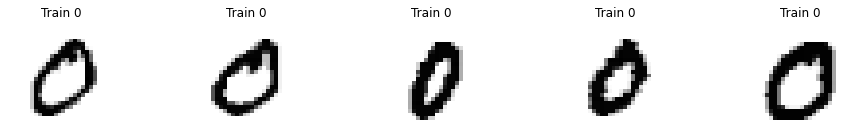

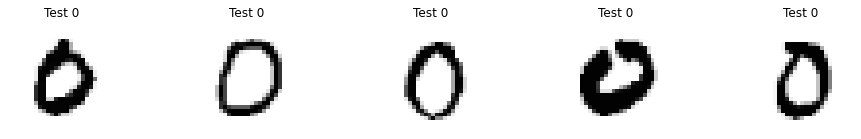

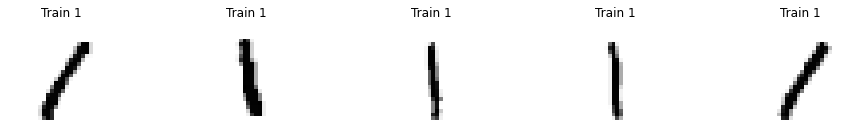

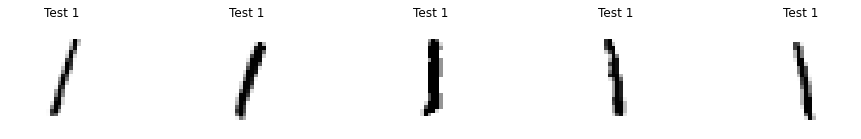

In [16]:
dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin = buildDataSet()
print("Checking shapes for class 0 (train) : ",dataset_train[0].shape)
print("Checking shapes for class 0 (test) : ",dataset_test[0].shape)
print("Checking first samples")
for i in range(2):
    DrawPics(dataset_train[i],5,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],5,template='Test {}',classnumber=i)

## I layer TripletLoss e PredictionLayer

In [ ]:
class TripletLossLayer(Layer):
    """
        Layer object to minimise the triplet loss.
        Here we implement the Bayesian Personal Ranking triplet loss.
    """
    def __init__(self, **kwargs):
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        """
            Triplet loss function.
            We make use of log-loss for numerical purposes.
        """
        anchor, positive, negative = inputs
        p_score = tf.math.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis = -1)
        n_score = tf.math.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis = -1)
        return tf.reduce_sum(tf.maximum(tf.subtract(p_score, n_score) , 0))
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

class PredictionLayer(Layer):
    """
        Layer object to predict positive matches.
    """
    def __init__(self, **kwargs):
        super(PredictionLayer, self).__init__(**kwargs)
    
    def rec_similarity(self, inputs):
        """
            rec_similarity function
        """
        anchor, item = inputs
        score = tf.math.reduce_sum(tf.square(tf.subtract(anchor, item)), axis = -1)
        return score
    
    def call(self, inputs):
        pred = self.rec_similarity(inputs)
        return pred

### Costruire le reti di training a predizione

Nelle celle seguenti dovrete costruire (tramite funzione) due reti (**che condividano i pesi**) una per il training (che quindi abbia come input delle triplette) e una per il predict (che abbia come input due sole immagini e restituisca il loro score di *vicinanza*.

In [ ]:
def buildPredictNetwork(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
    # Convolutional Neural Network
    network = Sequential()
    
    ## YOUR CODE HERE ##

    return network

def buildTrainingNetwork(input_shape, network, margin=0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
    # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    # TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')([encoded_a, encoded_p, encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train

## Compilare il modello

Dopo l'esecuzione della cella in basso, il tipo di grafico del modello dovrebbe essere questo.

![](https://github.com/CrimyTheBold/tripletloss/raw/8fa17e4cabf80343b5f766fb88a41bc067d7946a/02%20model.png)

In [ ]:
network_predict = build_network(input_shape,embeddingsize=10)
network_train = build_model(input_shape,network_predict)
optimizer = Adam(lr = 0.00006)
network_train.compile(loss=None,optimizer=optimizer)
network_train.summary()
plot_model(network_train,show_shapes=True, show_layer_names=True, to_file='model.png')
print(network_train.metrics_names)
n_iteration=0

# The last line only works for my model. Available after solutions are given.
# network_train.load_weights('mnist-160k_weights.h5')

#### Verificare che i modelli condividano i pesi

Potete verificare che i modelli train e predict condividano i layer in modo che allenare il primo aggiorni i pesi del secondo. Tramite questa cella stampate le posizioni di memoria dei layer e verificate che corrispondano.

In [ ]:
network_train.layers

In [ ]:
network_predict.layers

## Costruire il training set

Dobbiamo costruire delle triplette per allenare il modello. Utilizzeremo delle funzioni per costruire batch di triplette su cui svolgeremo il training.

Prima costruiremo delle triplette random, poi batch di triplette "hard" che allenano il modello in modo più efficiente.

In [ ]:
def get_batch_random(batch_size,s="train"):
    """
    Create batch of APN triplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 

    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (batch_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h, c = X[0].shape
    
    
    # initialize result
    triplets=[np.zeros((batch_size,h, w,c)) for i in range(3)]
    
    for i in range(batch_size):
        #Pick one random class for anchor
        ## YOUR CODE HERE ##
        
        #Pick two different random pics for this class => A and P
        [idx_A,idx_P] =  ## YOUR CODE HERE ##
        
        #Pick another class for N, different from anchor_class
        negative_class = (anchor_class + np.random.randint(1,n_classes)) % n_classes
        nb_sample_available_for_class_N = X[negative_class].shape[0]
        
        #Pick a random pic for this negative class => N
        idx_N =  ## YOUR CODE HERE ##

        triplets[0][i,:,:,:] = X[anchor_class][idx_A,:,:,:]
        triplets[1][i,:,:,:] = X[anchor_class][idx_P,:,:,:]
        triplets[2][i,:,:,:] = X[negative_class][idx_N,:,:,:]

    return triplets

Una funzione per visualizzare le triplette scelte.

In [17]:
def drawTriplets(tripletbatch, nbmax=None):
    """display the three images for each triplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            axis("off")
            plt.imshow(tripletbatch[i][row,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(labels[i])

Per costruire *hard triplets* dobbiamo prendere esempi negativi e positivi i più vicini possibili tra loro. Per fare ciò calcoliamo la distanza tramite una funzione `compute_dist`.

In [ ]:
# Computing distance
def compute_img_dist(a,b):
    return np.sum(np.square(a-b), axis = 1)

def get_batch_hard(draw_batch_size, hard_batchs_size, norm_batchs_size, network = network_predict, s="train"):
    """
    Create batch of APN "hard" triplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add

    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test

    m, w, h, c = X[0].shape
    
    
    # Step 1 : pick a random batch to study
    ## YOUR CODE HERE ##
    
    # Step 2 : compute the loss with current network : d(A,P)-d(A,N). The alpha parameter here is omited here since we want only to order them
    studybatchloss = np.zeros((draw_batch_size))
    
    # Compute embeddings for anchors, positive and negatives
    A = network.predict(studybatch[0])
    P = network.predict(studybatch[1])
    N = network.predict(studybatch[2])
    
    # Compute d(A,P)-d(A,N)
    studybatchloss = ## YOUR CODE HERE ##
    
    # Sort by distance (high distance first) and take the index
    selection = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
    
    # Draw other random samples from the batch
    selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    selection = np.append(selection,selection2)
    
    triplets = ## YOUR CODE HERE ##
    
    return triplets

Verifichiamo con un plot

In [ ]:
triplets = get_batch_random(2)
print("Checking batch width, should be 3 : ",len(triplets))
print("Shapes in the batch A:{0} P:{1} N:{2}".format(triplets[0].shape, triplets[1].shape, triplets[2].shape))
drawTriplets(triplets)
hardtriplets = get_batch_hard(50,1,1,network)
print("Shapes in the hardbatch A:{0} P:{1} N:{2}".format(hardtriplets[0].shape, hardtriplets[1].shape, hardtriplets[2].shape))
drawTriplets(hardtriplets)

Esempio di iperparametri, cmbiateli secondo il vostro modello.

In [18]:
# Hyper parameters
evaluate_every = 1000 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 80000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on

#### Validazione

In [ ]:
# Computing embeddings distance
def compute_dist(a,b):
    return np.sum(np.square(a-b))

def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds, auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (n_classes, n_classes) 
    '''
    res = np.zeros((n_classes, n_classes))
    
    ref_images = np.zeros((n_classes, img_rows, img_cols,1))
    
    #generates embeddings for reference images
    for i in range(n_classes):
        ref_images[i,:,:,:] = dataset_test[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(n_classes):
        for j in range(n_classes):
            res[i,j] = compute_dist(ref_embeddings[i], ref_embeddings[j])
    return res

def draw_interdist(network,n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(n_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(n_classes))

    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()

In [ ]:
#Testing on an untrained network
probs,yprob = compute_probs(network_predict,x_test_origin[:500,:,:,:],y_test_origin[:500])
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(network_predict,n_iteration)

In [ ]:
def DrawTestImage(network, images, refidx=0):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (N)
    
    '''
    N=4
    _, w,h,c = dataset_test[0].shape
    nbimages=images.shape[0]
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((nb_classes,w,h,c))
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset_test[i][refidx,:,:,:]
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        #Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,nb_classes+1,1)
        axis("off")
        plotidx = 2
            
        #Draw this image    
        plt.imshow(images[i,:,:,0],vmin=0, vmax=1,cmap='Greys')
        subplot.title.set_text("Test image")
            
        for ref in range(nb_classes):
            #Compute distance between this images and references
            dist = compute_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,nb_classes+1,plotidx)
            axis("off")
            plt.imshow(ref_images[ref,:,:,0],vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1

In [ ]:
for i in range(3):
    DrawTestImage(network,np.expand_dims(dataset_train[i][0,:,:,:],axis=0))

### Train del modello

In [ ]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
dummy_target = [np.zeros((batch_size,15)) for i in range(3)]
for i in range(1, n_iter+1):
    triplets = get_batch_hard(200,16,16,network)
    loss = network_train.train_on_batch(triplets, None)
    n_iteration += 1
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,loss,n_iteration))
        probs,yprob = compute_probs(network,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
        #draw_roc(fpr, tpr)

### Validazione

In [ ]:
#Full evaluation
probs,yprob = compute_probs(network,x_test_origin,y_test_origin)
fpr, tpr, thresholds,auc = compute_metrics(probs,yprob)
draw_roc(fpr, tpr,thresholds)
draw_interdist(network,n_iteration)

In [ ]:
for i in range(3):
    DrawTestImage(network,np.expand_dims(dataset_train[i][0,:,:,:],axis=0))

In [ ]:
draw_interdist(network_predict,n_iteration)